# Linking between data (AID) and algorithm (SRGAN).
1) Linking to drive

2)  Training the network
 

## Import and linking to drive

In [ ]:
## Run once to link to google drive using GCP
#!sudo apt-get install google-drive-ocamlfuse
#!sudo add-apt-repository ppa:alessandro-strada/ppa
#!sudo apt-get update
#!sudo apt-get install google-drive-ocamlfuse

In [ ]:
#!google-drive-ocamlfuse -headless -id=553698332080-4ilebkr6tajj9d4on76a6sfjilo8dbob.apps.googleusercontent.com -secret=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

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

import random

%matplotlib inline

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Resize, RandomVerticalFlip, RandomHorizontalFlip, Normalize
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

from pathlib import Path
import re

# Linking up drive and initialization

In [3]:
#Initializing google drive to a folder
#if not os.path.exists("./acv"):
#  os.makedirs("./acv")

#!google-drive-ocamlfuse acv

/bin/bash: google-drive-ocamlfuse: command not found


In [4]:
#os.chdir('/content/acv/Courses/COMS 4995-6 - Applied Computer Vision/Group Project/Codebase/AID')

FileNotFoundError: ignored

In [5]:
os.chdir('/content/drive/MyDrive/Courses/COMS 4995-6 - Applied Computer Vision/Group Project/Codebase/AID/')

# Data loader

In [6]:
#Define scale level
scale = 2

(600, 600)
torch.Size([3, 600, 600])
(600, 600, 3)


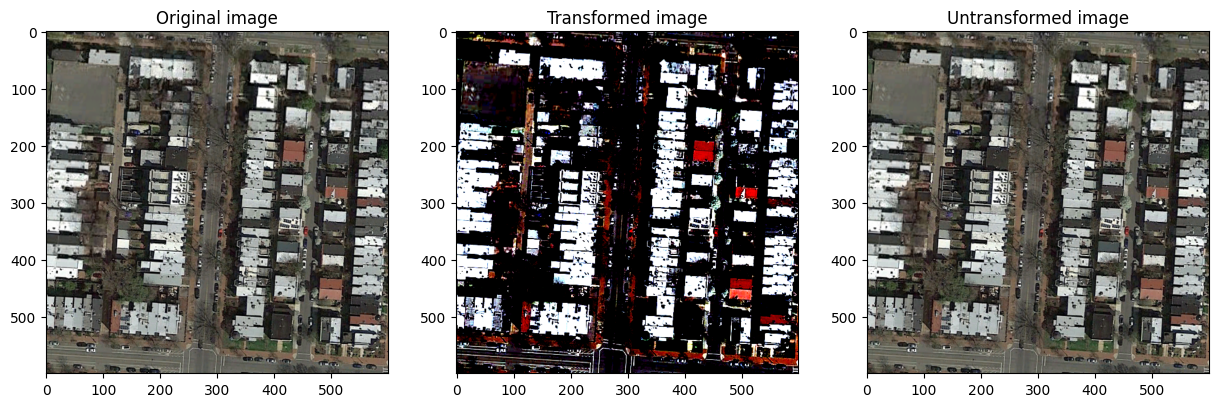

In [7]:
#Transform functions
data_unnormalize = transforms.Compose([
            transforms.Normalize(mean=[0, 0, 0], std=(1/0.2118,1/0.1872,1/0.1839,)),
            transforms.Normalize(mean=(-0.3911,-0.4033,-0.3585,), std=[1, 1, 1])
        ])

train_transforms = transforms.Compose([            
            transforms.ToTensor(),            # Convert the image to a tensor
            Normalize((0.3911,0.4033,0.3585,), (0.2118,0.1872,0.1839,)) 
        ])
flip_transform_vertical = transforms.Compose([
            RandomVerticalFlip(p=1)
        ])

flip_transform_horizontal = transforms.Compose([
            RandomHorizontalFlip(p=1)
        ])
      
test_transforms = transforms.Compose([            
            transforms.ToTensor(),            # Convert the image to a tensor 
            Normalize((0.3911,0.4033,0.3585,), (0.2118,0.1872,0.1839,))        
        ])

#Unit testing for normalize and unnormalize
img_sample = Image.open('../../Data/AID/AIDx1/DenseResidential/denseresidential_9.png').convert('RGB')
img_sample2 = train_transforms(img_sample)
img_sample3 = data_unnormalize(img_sample2).permute(1, 2, 0).numpy()

print(img_sample.size)
print(img_sample2.shape)
print(img_sample3.shape)

fig, axs = plt.subplots(1, 3, figsize=(15, 10))

# Display the LR and HR images using matplotlib
axs[0].imshow(img_sample)
axs[0].set_title('Original image')
axs[1].imshow(img_sample2.permute(1, 2, 0).numpy())
axs[1].set_title('Transformed image')
axs[2].imshow(img_sample3)
axs[2].set_title('Untransformed image')

plt.show()

In [8]:
class AIDSRDataset(Dataset):
    def __init__(self, dataLR_files, dataHR_files, upscale_factor):
        self.p = 0.5

        self.dataLR_files = np.genfromtxt(dataLR_files,dtype='str')
        self.dataHR_files = np.genfromtxt(dataHR_files,dtype='str')
        self.upscale_factor = upscale_factor
                  
    def __len__(self):
        return len(self.dataLR_files)
    
    def __getitem__(self, idx):
        # Load the image from disk 
        imgLR = Image.open(self.dataLR_files[idx]).convert('RGB') 
        imgHR = Image.open(self.dataHR_files[idx]).convert('RGB')
        
        # Apply the data transformations 
        img_lr = train_transforms(imgLR)
        img_hr = train_transforms(imgHR)

        if random.random() < 0.5:
            img_lr = flip_transform_vertical(img_lr)
            img_hr = flip_transform_vertical(img_hr)

        if random.random() < 0.5:
            img_lr = flip_transform_horizontal(img_lr)
            img_hr = flip_transform_horizontal(img_hr)
        
        return img_lr, img_hr

In [9]:
ls

AID-checkfiles.ipynb           AID-TrainTestSplit.ipynb
AID-DataPreprocessing.ipynb    check_mean.m
AID-EDSR-04152023-1.ipynb      SRGAN-PyTorch-main/
AID-SRresnet-04152023-1.ipynb  SRGAN-TrainTestSplit.ipynb


In [10]:
# Create an instance of the AIDSRDataset
train_dataset = AIDSRDataset(dataLR_files='../../Data/AID/Train1_5class/train_LRx' + str(scale) + '.csv',dataHR_files='../../Data/AID/Train1_5class/train_HR.csv', upscale_factor=scale)

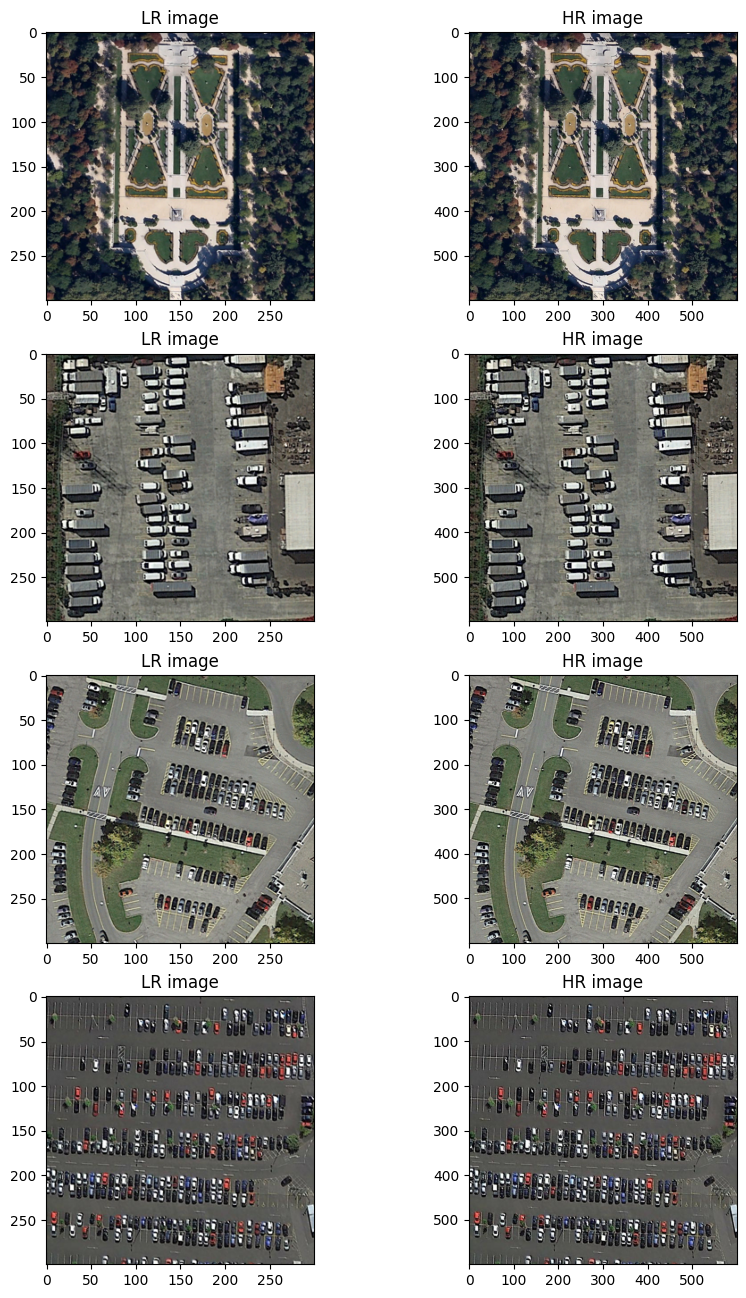

In [11]:
#Test to show data loader is working
batch_size = 4
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 1)

fig, axs = plt.subplots(batch_size, 2, figsize=(10, 4*batch_size))

for batch in dataloader:
  img_lr_batch, img_hr_batch = batch
  for i in range(len(img_lr_batch)): 
    img_lr = img_lr_batch[i]
    img_hr = img_hr_batch[i]
    
    if random.random() < 0.5:
        img_lr = flip_transform_vertical(img_lr)
        img_hr = flip_transform_vertical(img_hr)

    if random.random() < 0.5:
        img_lr = flip_transform_horizontal(img_lr)
        img_hr = flip_transform_horizontal(img_hr)

    img_LR = data_unnormalize(img_lr).permute(1, 2, 0).numpy()
    img_HR = data_unnormalize(img_hr).permute(1, 2, 0).numpy()
    
    # Display the LR and HR images using matplotlib
    axs[i,0].imshow(img_LR)
    axs[i,0].set_title('LR image')
    axs[i,1].imshow(img_HR)
    axs[i,1].set_title('HR image')
  break

plt.show()

# Running a sample training of SRresnet

In [21]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="iCCP: known incorrect sRGB profile")

In [17]:
!pip install libpng-bins

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 8.3 MB/s eta 0:00:00


In [22]:
!python ./SRGAN-PyTorch-main/train_srresnet.py

2023-04-16 05:15:16.236550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 05:15:17.132334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
libpng warning: iCCP: known incorrect sRGB profile
Load all datasets successfully.
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Build `srresnet_x2` model successfully.
Define all loss functions successfully.
Define all optimizer functions successfully.
Check whether to load pretrained model weights...
Pretrained model weights not found.
Check whether the pretrained model is restored...
Resume training model not found. Start training from scratch.
libpng warning: iCCP: known incorrect sRGB profi